In [2]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import warnings
from matplotlib.animation import FuncAnimation
warnings.filterwarnings("ignore")

from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
radius_fuel, radius_buffer, radius_IPyC, radius_SiC, radius_OPyC = 400e-4, 475e-4, 510e-4, 546.7e-4, 566.7e-4
compact_radius,compact_height = 20 * radius_OPyC, 1

In [18]:


TRISO = openmc.Model()

''' 
Materials 
'''

SiC = openmc.Material(1,name='SiC')
SiC.add_elements_from_formula('SiC')
SiC.set_density('g/cm3',3.2)

PyC = openmc.Material(2,name = 'PyC')
PyC.add_element('C',1)
PyC.set_density('g/cm3',1.9)

Carbon = openmc.Material(3,name = 'Carbon Buffer')
Carbon.add_element('C',1)
Carbon.set_density('g/cm3',1)

UCO = openmc.Material(4,name='Fuel')
UCO.add_element('U',3,enrichment=19.75,)
UCO.add_element('C',3)
UCO.add_element('O',2)
UCO.set_density('g/cm3',10.75)

TRISO.materials = openmc.Materials([SiC,PyC,Carbon,UCO])


'''
Geometry
'''

radius_fuel, radius_buffer, radius_IPyC, radius_SiC, radius_OPyC = 400e-4, 475e-4, 510e-4, 546.7e-4, 566.7e-4
compact_radius,compact_height = 20 * radius_OPyC, 1
compact_surface = openmc.ZCylinder(r = compact_radius, surface_id = 1,boundary_type = 'reflective')
top,bottom = openmc.ZPlane(z0 = compact_height/2,surface_id = 2,boundary_type ='reflective'), openmc.ZPlane(z0 = -compact_height/2, surface_id = 3,boundary_type = 'reflective')
compact_region =  -compact_surface & - top & + bottom
pf = .3

centroids = openmc.model.pack_spheres(radius = radius_OPyC,region=compact_region,pf=pf, seed=1)






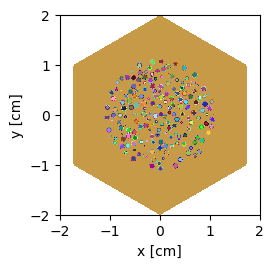

In [21]:
def triso_surfs(r,x,y,z):
    return openmc.Sphere(r=r,x0=x,y0=y,z0=z)
fuel_surfs = [triso_surfs(radius_fuel,x,y,z) for x,y,z in centroids]
buffer_surfs = [triso_surfs(radius_buffer,x,y,z) for x,y,z in centroids]
IPyC_surfs = [triso_surfs(radius_IPyC,x,y,z) for x,y,z in centroids]
SiC_surfs = [triso_surfs(radius_SiC,x,y,z) for x,y,z in centroids]
OPyC_surfs = [triso_surfs(radius_OPyC,x,y,z) for x,y,z in centroids]

compact_surface = openmc.model.HexagonalPrism(edge_length=compact_height*2,corner_radius=radius_OPyC,boundary_type='white')
index = len(fuel_surfs)

#f is fuel, b is buffer, ip is inner pyc, s is sic, op is opyc

fuel_cells = [openmc.Cell(cell_id=i,region = -f,fill = UCO) for i,f in enumerate(fuel_surfs)]
buffer_cells = [openmc.Cell(cell_id = i+index,region = +f&-b,fill = Carbon) for i,(f,b) in enumerate(zip(fuel_surfs,buffer_surfs))]
ipyc_cells = [openmc.Cell(cell_id = i+index*2,region = +b&-ip,fill = PyC) for i,(b,ip) in enumerate(zip(buffer_surfs,IPyC_surfs))]
sic_cells = [openmc.Cell(cell_id = i+index*3,region = +ip&-s,fill = SiC) for i,(ip,s) in enumerate(zip(IPyC_surfs,SiC_surfs))]
opyc_cells = [openmc.Cell(cell_id = i+index*4,region = +s&-op,fill = PyC) for i,(s,op) in enumerate(zip(SiC_surfs,OPyC_surfs))]

Matrix_region = +bottom &-top & - compact_surface
for op in OPyC_surfs:
    Matrix_region &= + op
Matrix_cell = openmc.Cell(region=Matrix_region,fill = Carbon)

#theres probably a better way to do this
cells = fuel_cells
cells.extend(buffer_cells)

cells.extend(ipyc_cells)

cells.extend(sic_cells)

cells.extend(opyc_cells)

cells.append(Matrix_cell)

universe = openmc.Universe(cells = cells)
TRISO.geometry = openmc.Geometry(universe)
universe.plot(width = (4,4))
save_path = r'/Users/nglaser3/Downloads/'
plt.savefig('geometry.png',dpi = 600)
plt.show()

In [23]:
'''
Settings 
'''
TRISO.settings.source = openmc.IndependentSource(space=openmc.stats.Box(
    [-compact_radius, -compact_radius, -compact_height], [compact_radius, compact_radius, compact_height],only_fissionable=True))
TRISO.settings.batches = 400
TRISO.settings.inactive = 200
TRISO.settings.particles = 100000

flux_tally_zernike = openmc.Tally()
flux_tally_zernike.scores = ['kappa-fission']
zernike_filter = openmc.ZernikeFilter(order=300, x=0.0, y=0.0, r=compact_radius)
flux_tally_zernike.filters = [zernike_filter]
TRISO.tallies = openmc.Tallies([flux_tally_zernike])

TRISO.export_to_xml()

In [3]:
with openmc.StatePoint('statepoint.400.h5') as sp:
    df = sp.tallies[4].get_pandas_dataframe()

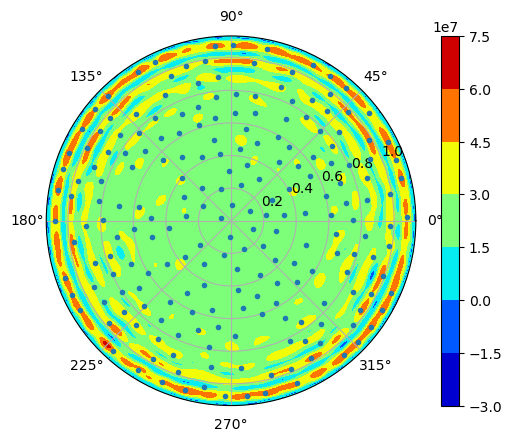

In [35]:
index = zern_order(4,df)
z_n = df['mean']#[:index]
zz = openmc.Zernike(z_n, compact_radius)
azimuths = np.radians(np.linspace(0, 360, 1000))
zeniths = np.linspace(0, compact_radius, 500)    
r, theta = np.meshgrid(zeniths, azimuths)
values = zz(zeniths, azimuths)
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
r_,theta_ = centroid_pos_cyl(x,y)
ax.plot(theta_,r_,'.')
contour_f = ax.contourf(theta, r, values, cmap='jet')
fig.colorbar(contour_f)
plt.show()
#plt.plot(zeniths,zz(zeniths,np.pi/2))
#plt.show()

In [4]:
def zern_order(n,df):
    '''
    n : max order to include in analysis
    df : dataframe of zernike filter
    '''
    index = len(df['zernike'])
    for i in range(len(df['zernike'])):
        order = df['zernike'][i]
        order = int(order.split(',')[0][1:])
        if order <= n:
            pass
        else:
            return i
            break
def zern_plot(n):
    index = zern_order(n,df)
    z_n = df['mean'][:index]
    zz = openmc.Zernike(z_n, compact_radius)

    values = zz(zeniths, azimuths)
    ax.set_title('Order {} Zernike Polynomial'.format(n))
    x,y = xy(r,theta)
    contour_f = ax.contourf(x, y, values, cmap='jet')
    #contour_f = ax.contourf(theta, r, values, cmap='jet')
    fig.colorbar(contour_f,cax=cax)
def find_centroids(geo_path,fuel_radius):
    geom = openmc.Geometry.from_xml(geo_path)
    cell_dict = geom.get_all_cells()
    centroids = []
    for cell_id in cell_dict.keys():
        cell = cell_dict[cell_id]
        if cell.fill.name == 'Fuel':
            surf_dic = cell.region.get_surfaces()
            surf = [surf_dic[x] for x in surf_dic.keys()][0]
            x,y,z = surf.x0, surf.y0, surf.z0
            if abs(z) < fuel_radius:
                centroids.append([x,y,z])
    cents = np.array(centroids)
    x,y,z = cents[:,0],cents[:,1],cents[:,2]
    return x,y,z
def circle(x,y,z,R,ord):
    '''
    x = x0
    y = y0
    z = z0
    R = Sphere radius
    '''
    r = (R**2-z**2)**.5
    theta = np.linspace(0,2*np.pi,ord)
    x_ = r*np.cos(theta)+x
    y_ = r*np.sin(theta)+y
    return x_,y_
def xy(r,theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x,y    

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-framerate', '4.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'TRISO_Z_300.mp4']' returned non-zero exit status 255.

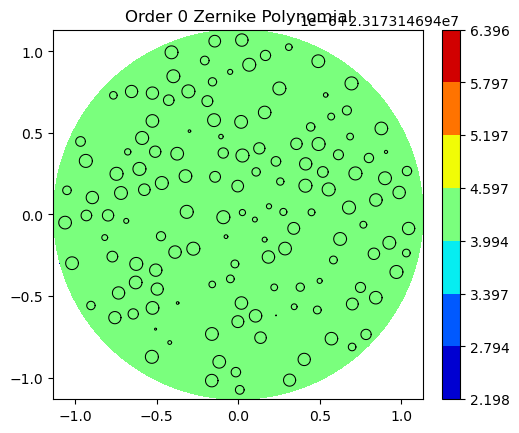

In [11]:
ords = np.arange(1,201)
azimuths = np.radians(np.linspace(0, 360, 1000)) 
zeniths = np.linspace(0, compact_radius, 500)    
r, theta = np.meshgrid(zeniths, azimuths)
fig, ax = plt.subplots()#figsize = (5,5))#subplot_kw=dict(projection='polar'))

div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
x,y,z = find_centroids('geometry.xml',radius_fuel)
circs = [circle(x0,y0,z0,radius_fuel,30) for x0,y0,z0 in zip(x,y,z)]
for circ in circs: 
    ax.plot(circ[0],circ[1],color = 'k',linewidth = .75)
ax.set_aspect('equal')
animation = FuncAnimation(fig, func=zern_plot, frames=200, interval=250)
animation.save('TRISO_Z_300.mp4')


In [ ]:
df